# Определение мошенических транзакций

## Описание проекта

Компании, выпускающие кредитные карты, могли распознавать мошеннические транзакции по кредитным картам, чтобы с клиентов не взималась плата за товары, которые они не покупали.Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, произошедшие за два дня, где у нас 492 мошенничества из 284 807 транзакций.
Нужно обучить модель, которая будет выявлять мошенничиские транзакции.

## Описание данных

**Time** - кол-во секунд, прошедших между этой транзакцией и первой транзакцией в наборе данных  
**V1-V28** - конфеденциальные признаки, которые не могут быть рассекречены  
**Amount** - Сумма транзакции  
**Class** - является ли операция мошеннической или нет (1 да, 0 нет)

## Этапы работы

1. Загрузить и изучить данные на заявленное описание.  
2. Провести предобработку данных, те проверить на пропуски и дубликаты.
3. Визуализировать признаки и проверить на выбросы.  
4. Проверить данные на мультиколлениарность.  
5. Построить несколько моделей и по результатам на кросс-валидации выбрать лучшую
6. Сделать выводы

## Загрузка данных

**Задача** Загрузить и изучить данные на заявленное описание.

```
!pip install imblearn -q
!pip install phik -q
!pip install torch -q
!pip install catboost -q
```

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,recall_score,f1_score,auc,precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RANDOM_STATE=42

In [ ]:
path1='creditcard.csv'
path2='/content/drive/My Drive/Colab Notebooks/creditcard.csv'
if os.path.exists(path1):
    df=pd.read_csv(path1)
elif os.path.exists(path2):
    df=pd.read_csv(path2)
else :
    print ('Something wrong')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Вывод** Данные соотвествуют заявленному описанию, можно двигаться дальше

## Предобаботка данных

**Задача** Провести предобработку данных, те проверить на пропуски и дубликаты.

In [ ]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [ ]:
df.duplicated().sum()

1081

In [ ]:
df.drop_duplicates(inplace=True)

**Вывод** В данных не было пропусков, но содержались дубликаты, которые впоследствии были устранены.

## Исследовательский анализ

**Задача** Построить гистограммы для признаков и проверить на выбросы.

In [ ]:
df_with_fraud = df[df['Class']==1]
df_without_fraud = df[df['Class']==0]


In [ ]:
?sns.histplot

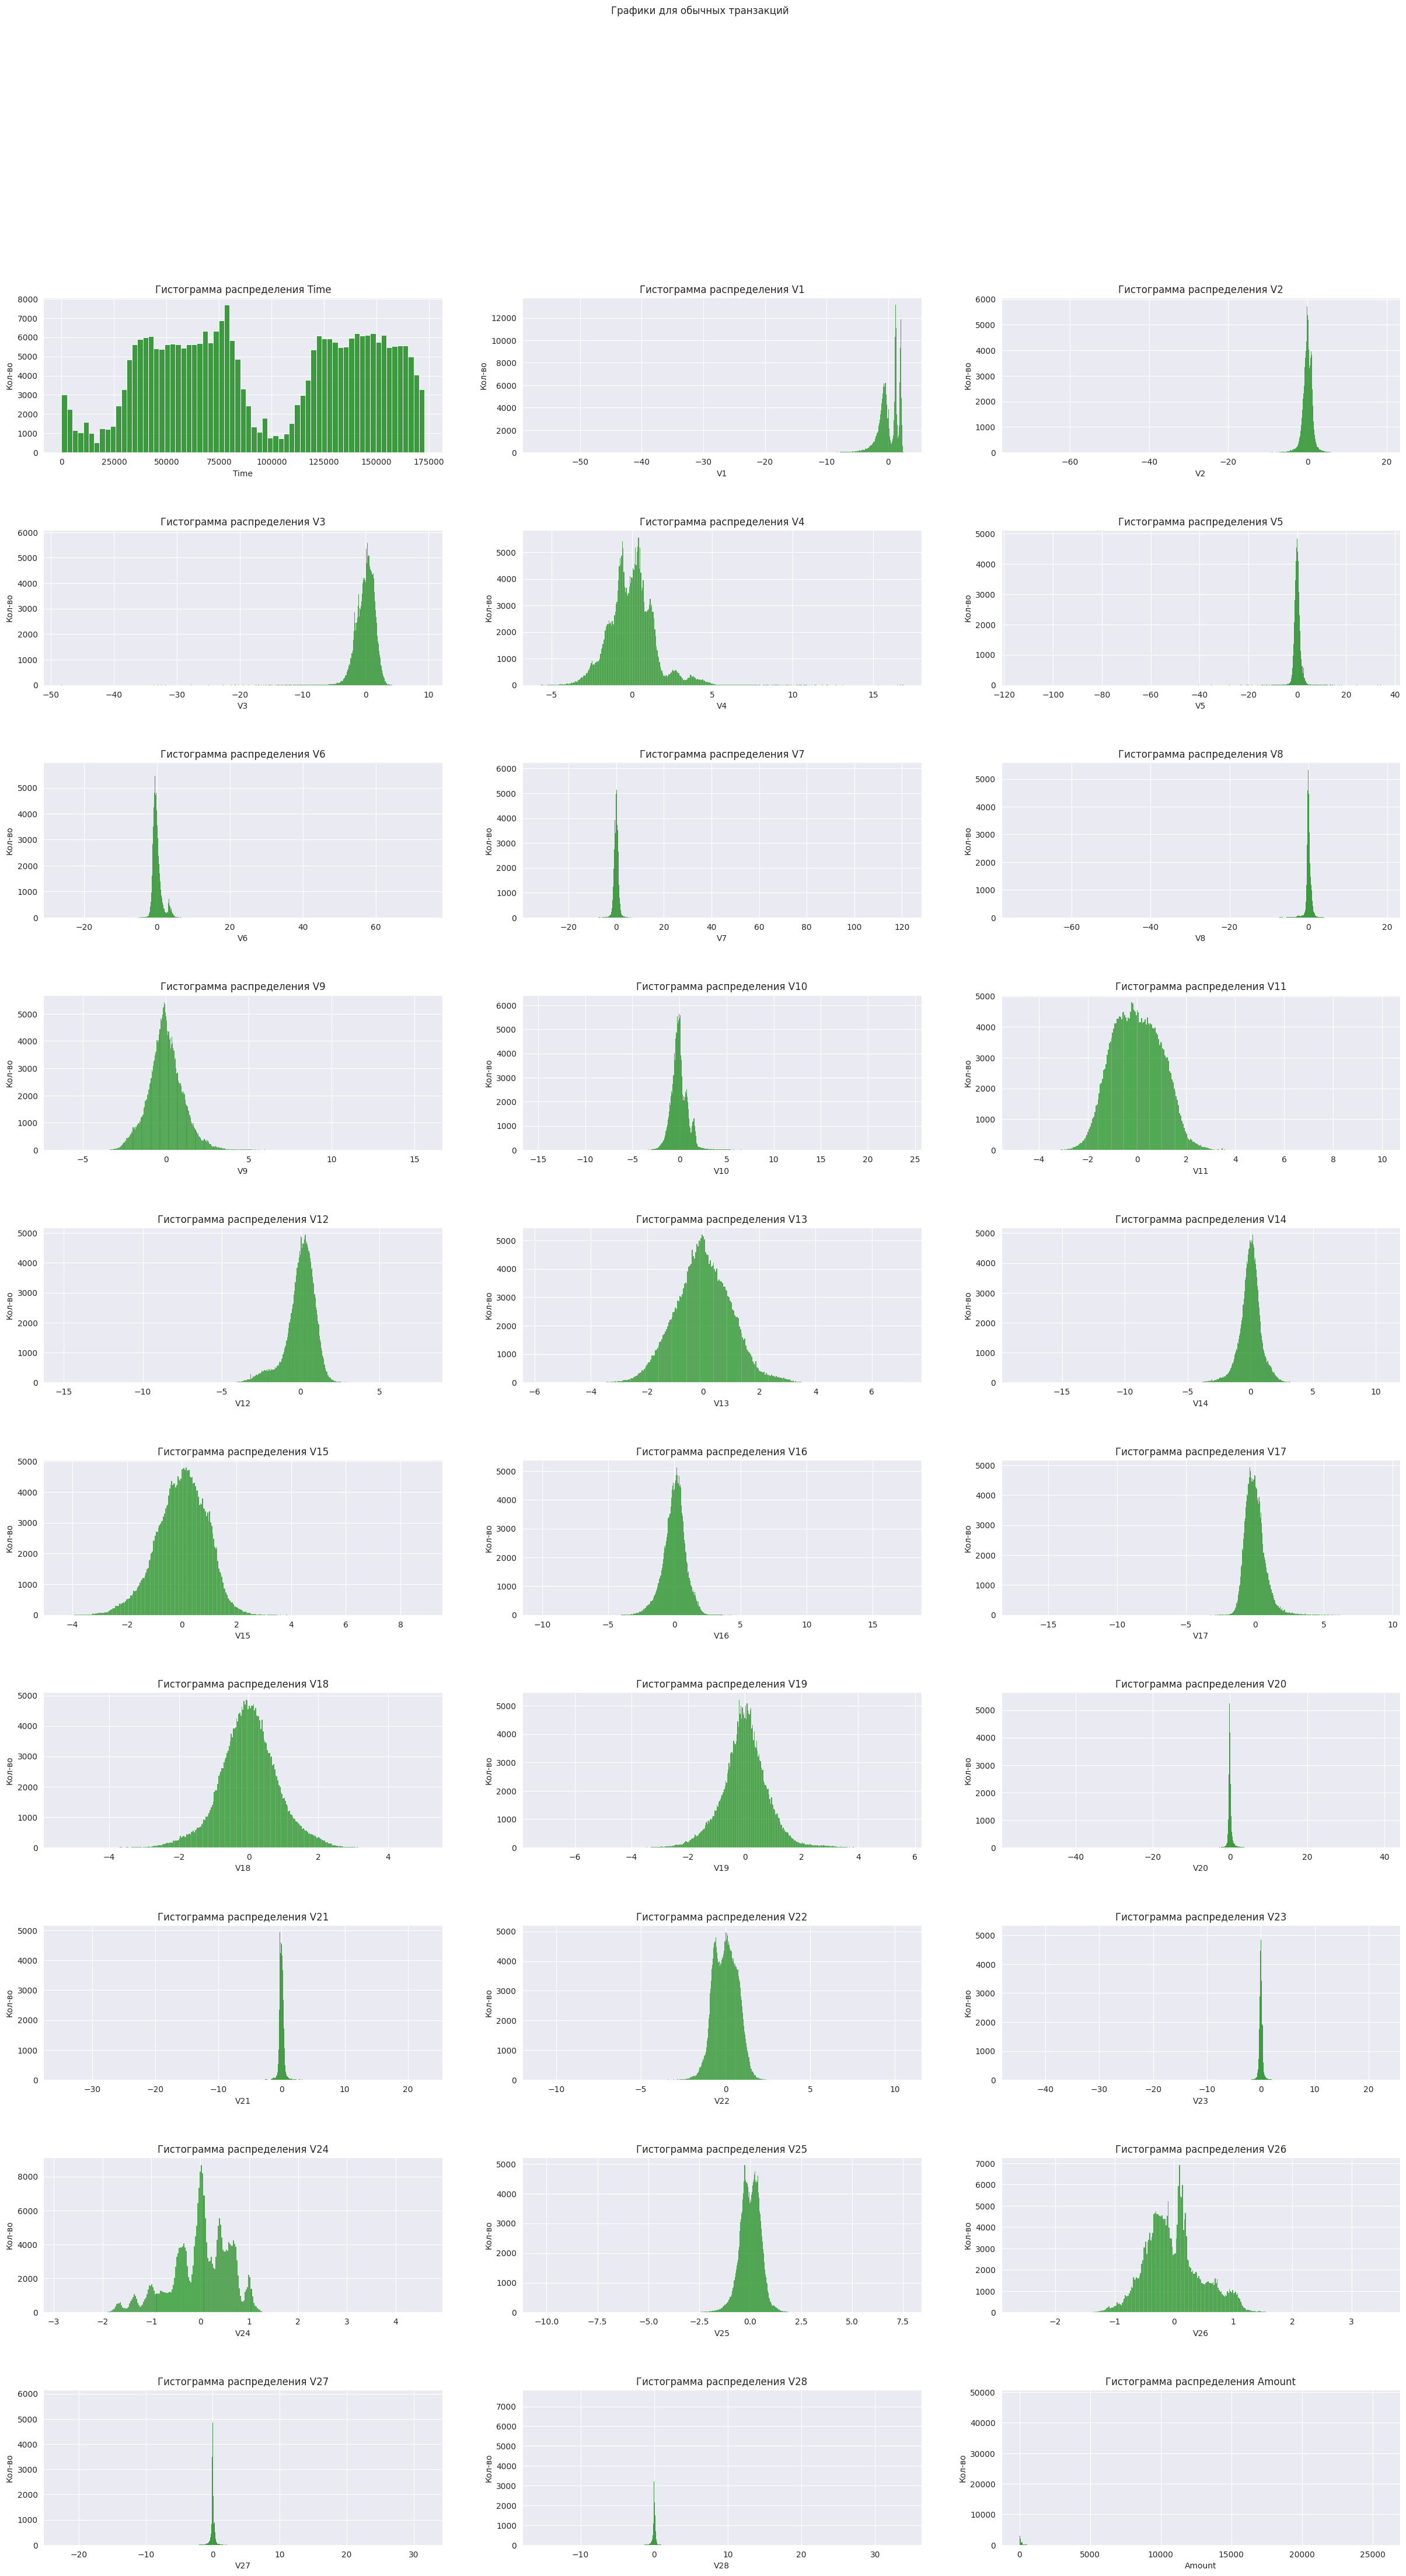

In [ ]:
X=df.columns[0:-1]
plot_func(df_without_fraud,X,False)

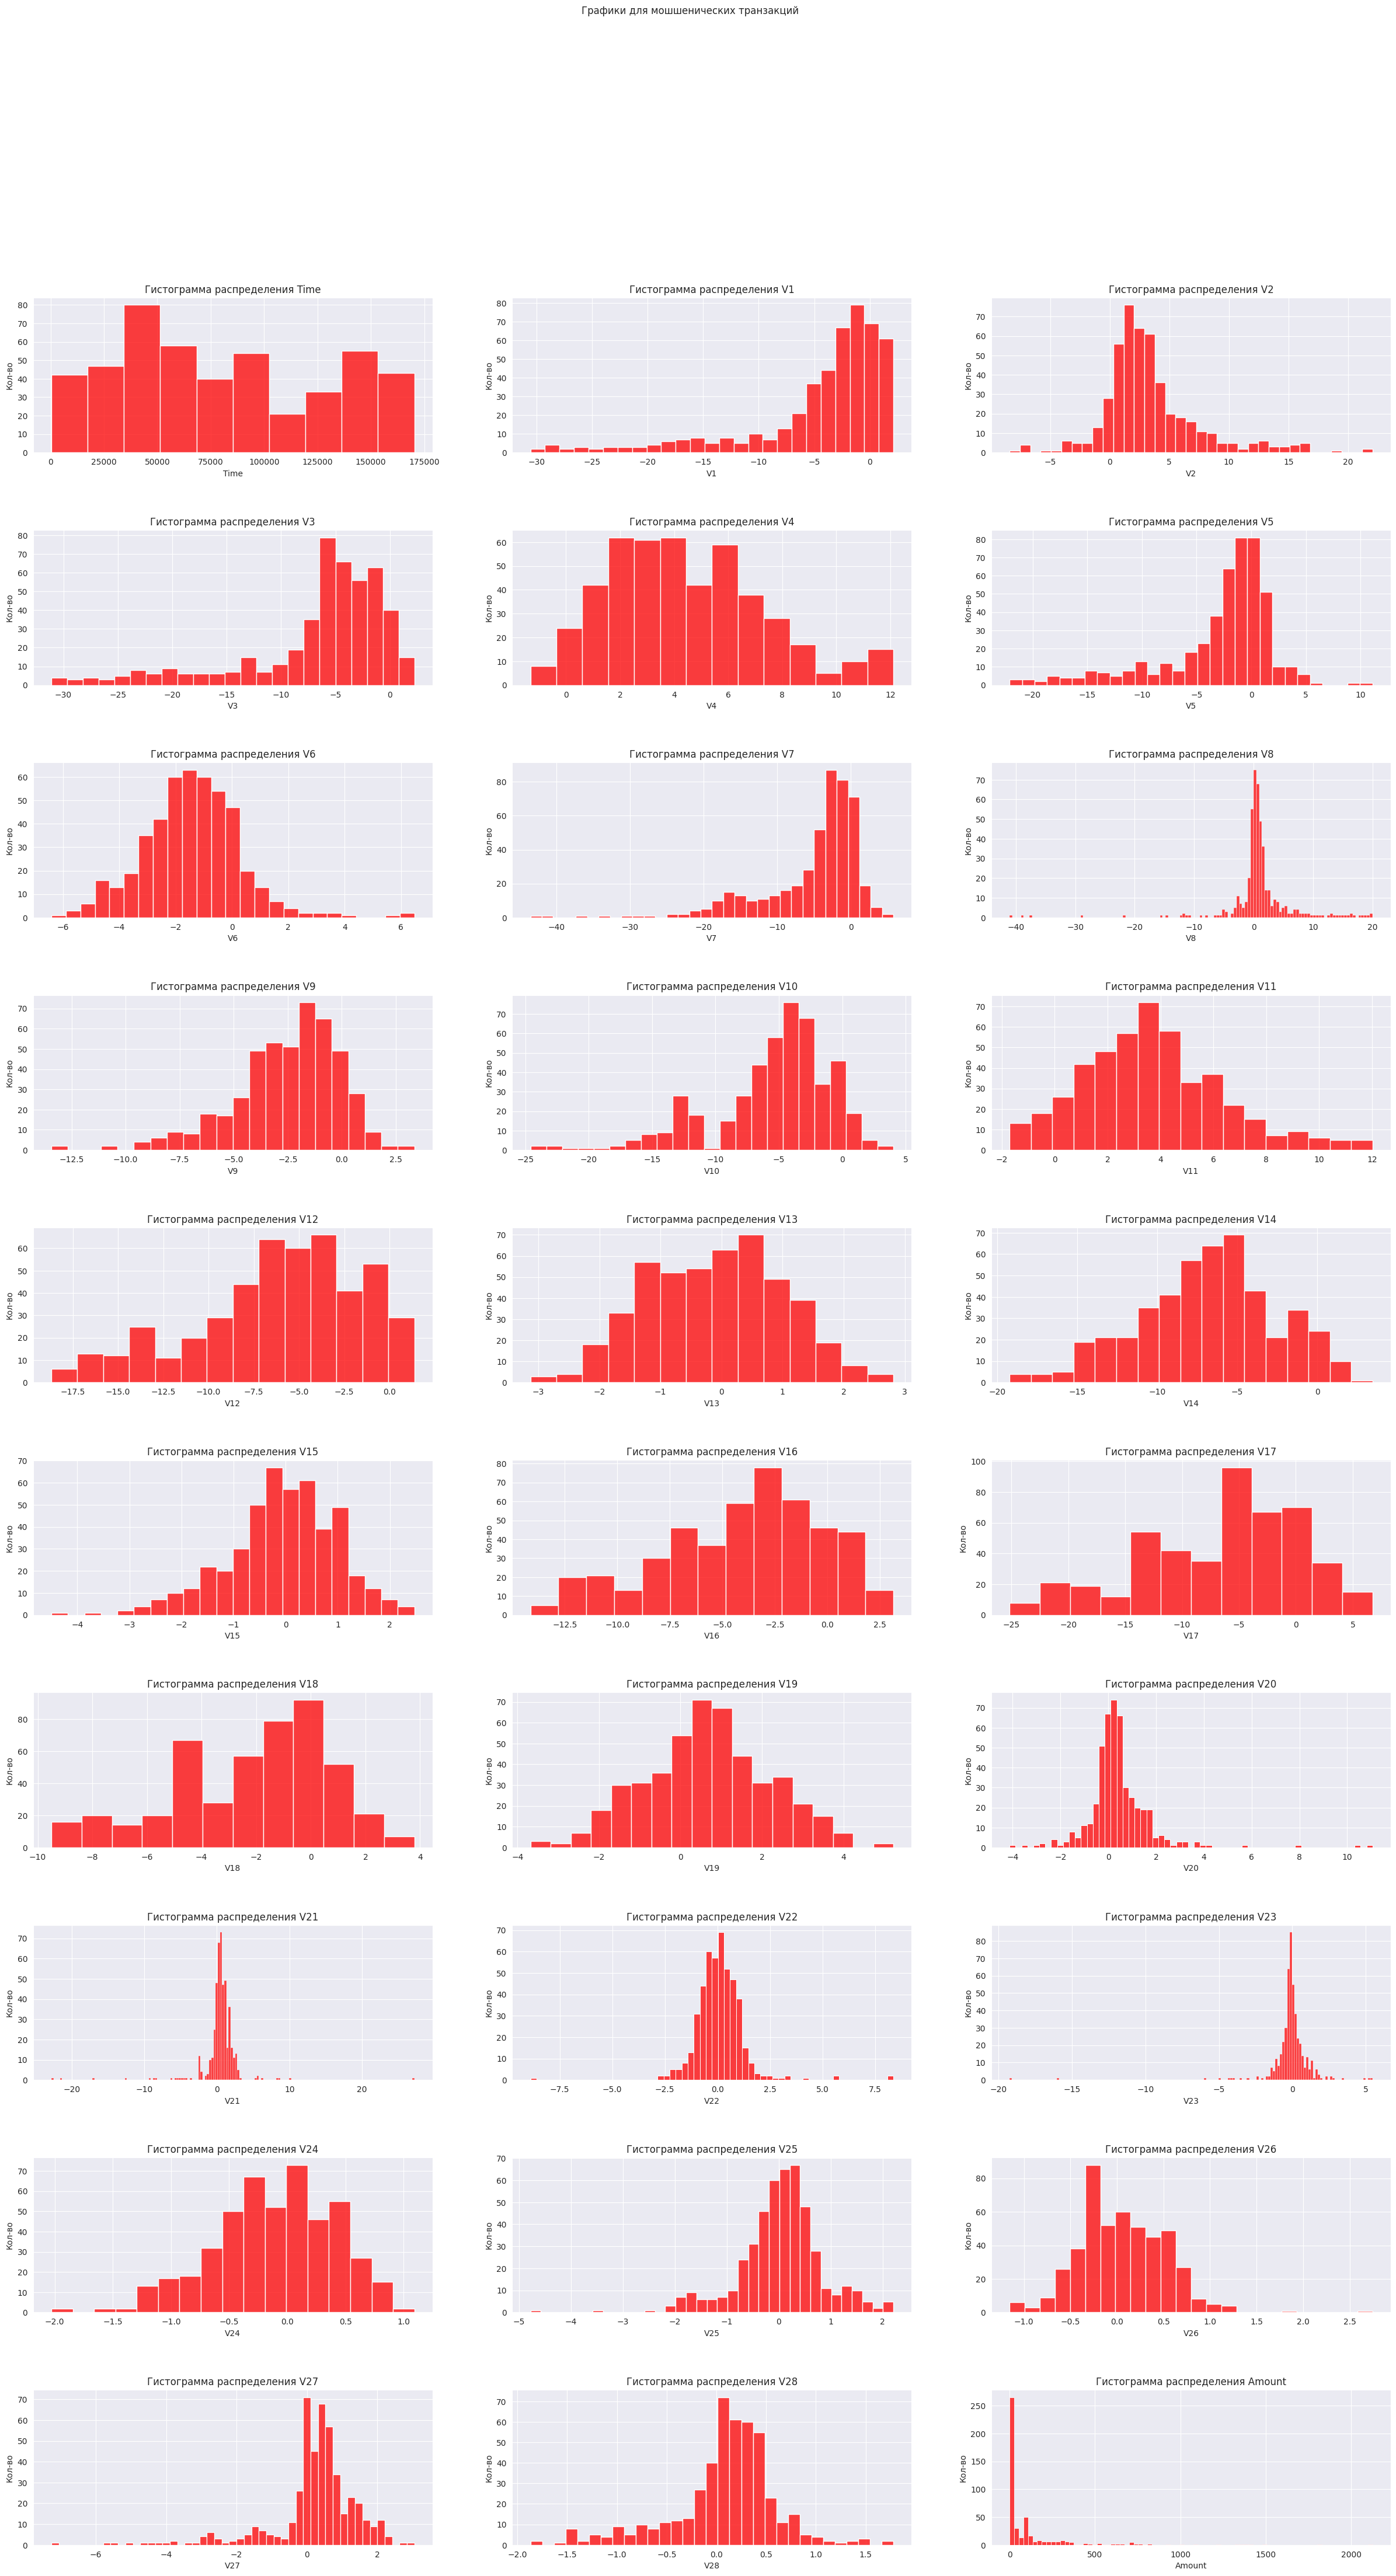

In [ ]:
X=df.columns[0:-1]
plot_func(df_with_fraud,X,True)

В датасете обычных транзакций очень много признаков с аномальными значениями, уберу их при помощи метода межквартильного размаха.

In [ ]:
def delete_outliers(data,columns):
  for column in columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    low_range = Q1 - 1.5 * IQR
    high_range = Q3 + 1.5 * IQR
    data = data[(data[column]<high_range)&(data[column]>low_range)]
  return data


In [ ]:
df_without_fraud = delete_outliers(df_without_fraud,df_without_fraud.columns[0:-1])

In [ ]:
df_without_fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0
12,10.0,1.249999,-1.221637,0.383930,-1.234899,-1.485419,-0.753230,-0.689405,-0.227487,-2.094011,...,-0.231809,-0.483285,0.084668,0.392831,0.161135,-0.354990,0.026416,0.042422,121.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284794,172777.0,-1.266580,-0.400461,0.956221,-0.723919,1.531993,-1.788600,0.314741,0.004704,0.013857,...,-0.157831,-0.883365,0.088485,-0.076790,-0.095833,0.132720,-0.028468,0.126494,0.89,0
284796,172780.0,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,60.00,0
284797,172782.0,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,5.49,0
284800,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0


IndexError: index 30 is out of bounds for axis 0 with size 30

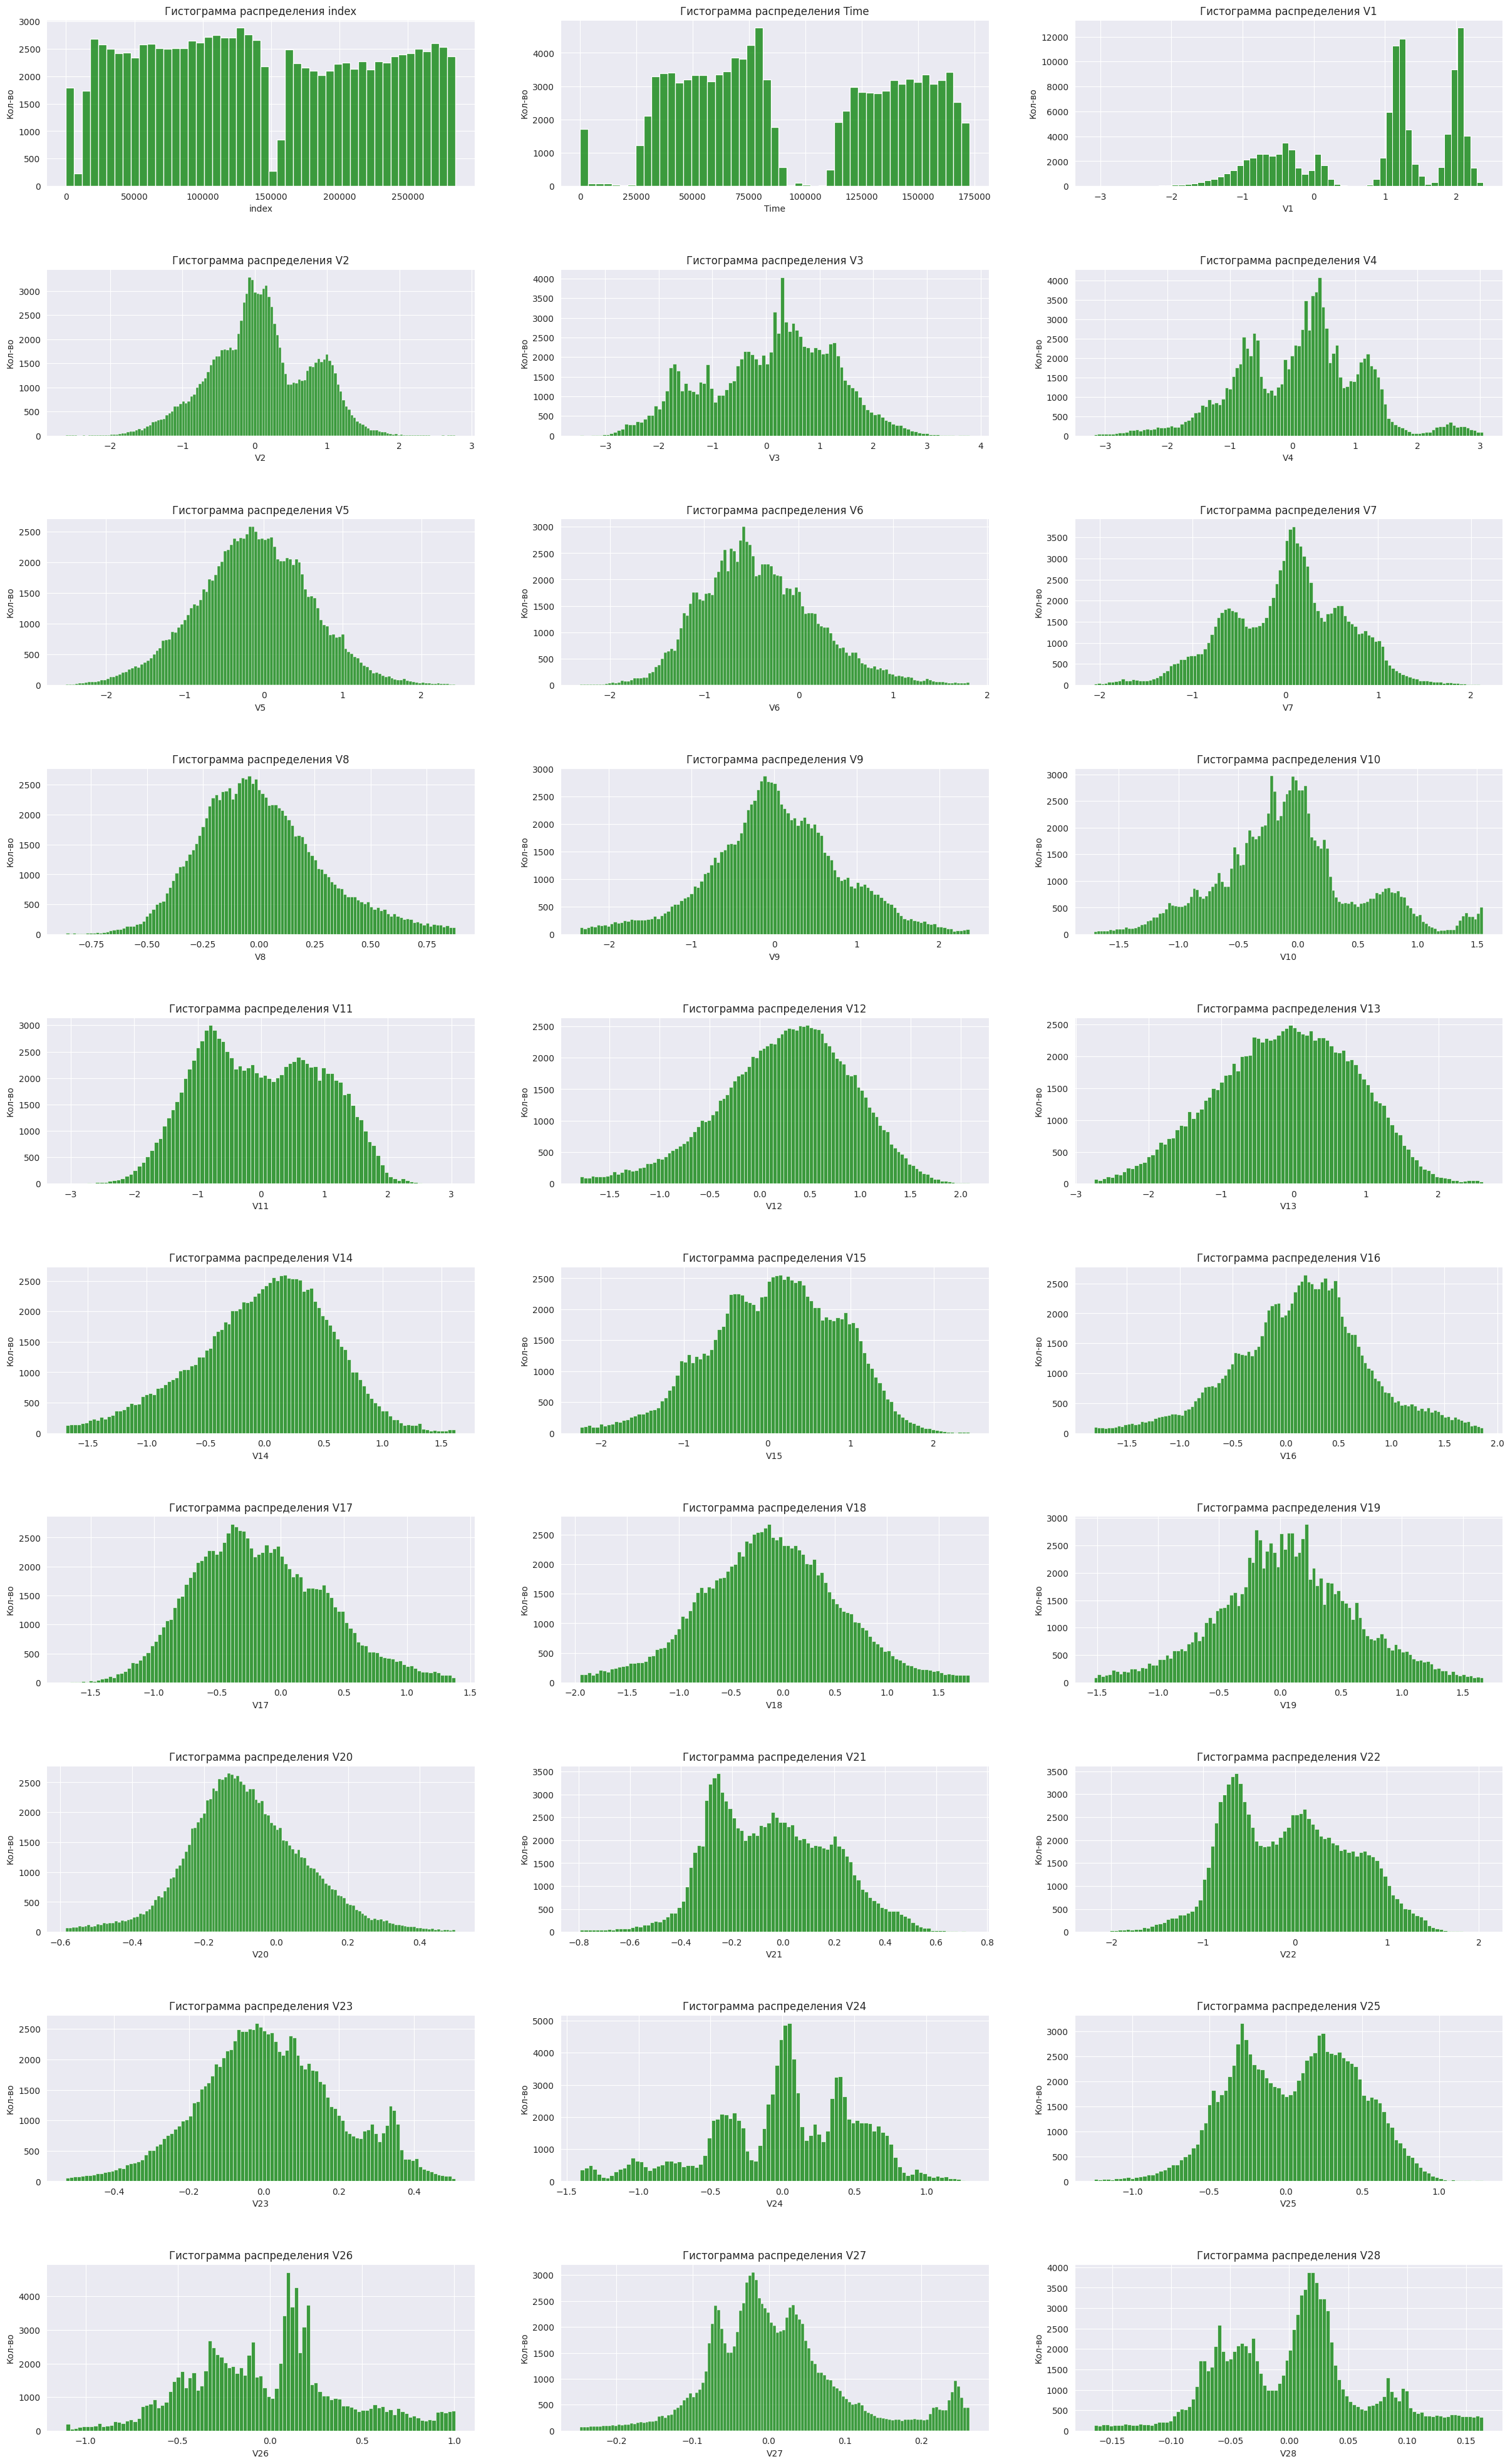

In [ ]:
X=df_without_fraud.columns[0:-1]
plot_func(df_without_fraud,X,False)

Как видно в данных наблюдаются аномалии. Изучу их более детальнее и устраню

In [ ]:
df_without_fraud['Time'] = np.log1p(df_without_fraud['Time'])
df_with_fraud['Time'] = np.log1p(df_with_fraud['Time'])

<ipython-input-16-c4602c0b5cc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_fraud['Time'] = np.log1p(df_with_fraud['Time'])


In [ ]:
def boxplot(data1,data2):
  fig,axes = plt.subplots(ncols = 2, nrows = 30, figsize=(30, 200))
  plt.subplots_adjust(hspace=0.5, wspace = 0.4)
  axes = axes.flatten()
  i = 0
  for column in data1.columns[0:-1]:
    sns.boxplot(data = data1, x = data1.columns[-1],y = column, ax = axes[i],color='red')
    sns.boxplot(data = data2, x = data2.columns[-1],y = column, ax = axes[i+1],color = 'green')
    i+=2
  plt.show()

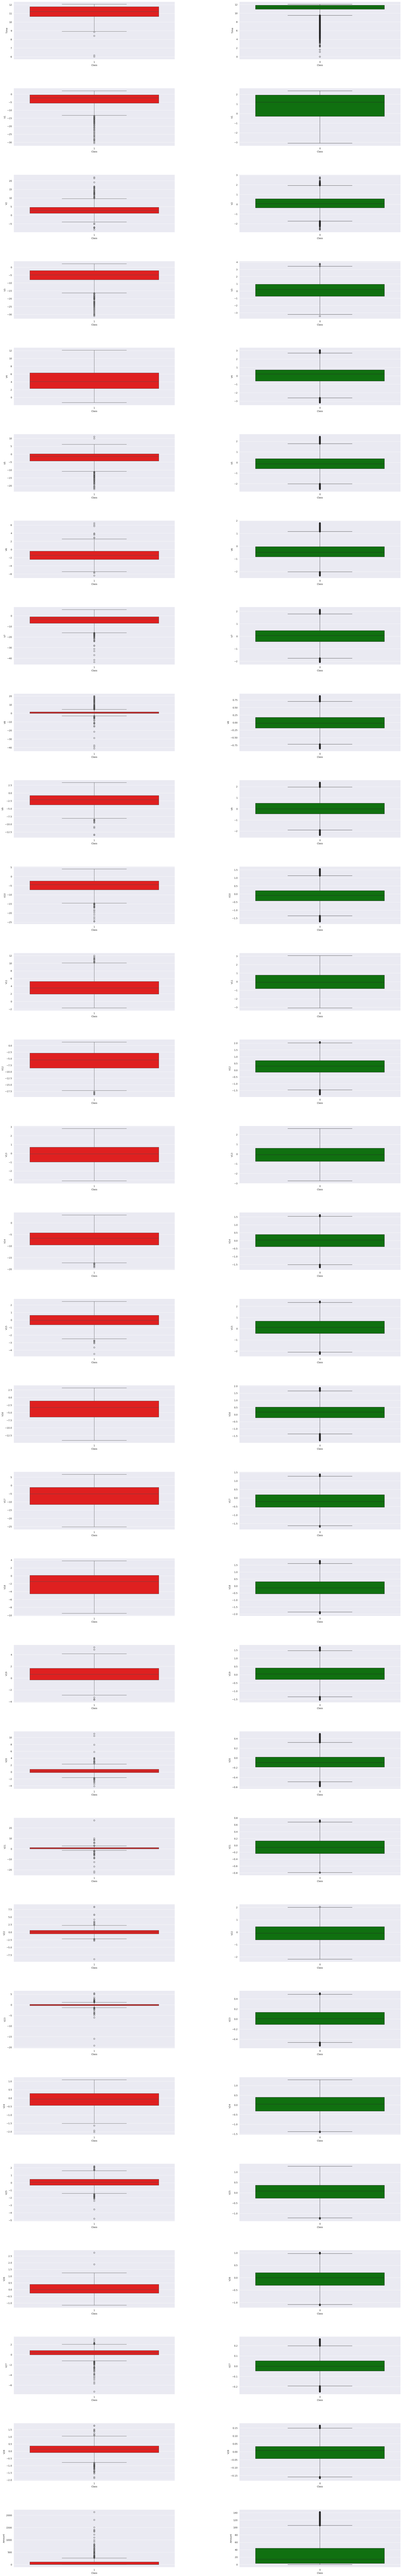

In [ ]:
boxplot(df_with_fraud,df_without_fraud)

**Вывод:**
1. Данные были разбиты на мошеннические транзакции и обычные, затем для обычных транзакций были удалены выбросы и аномалии.
2. Большинство признаков имеет распределение напоминающее нормальное по форме, признак 'Time' был приведен к логарифмическому виду для приближения к нормальному распредлелению.

## Корреляционный анализ

**Задача** Визуализировать как данные между собой коррелируют

In [ ]:
df_merged = pd.concat([df_with_fraud,df_without_fraud],axis=0)

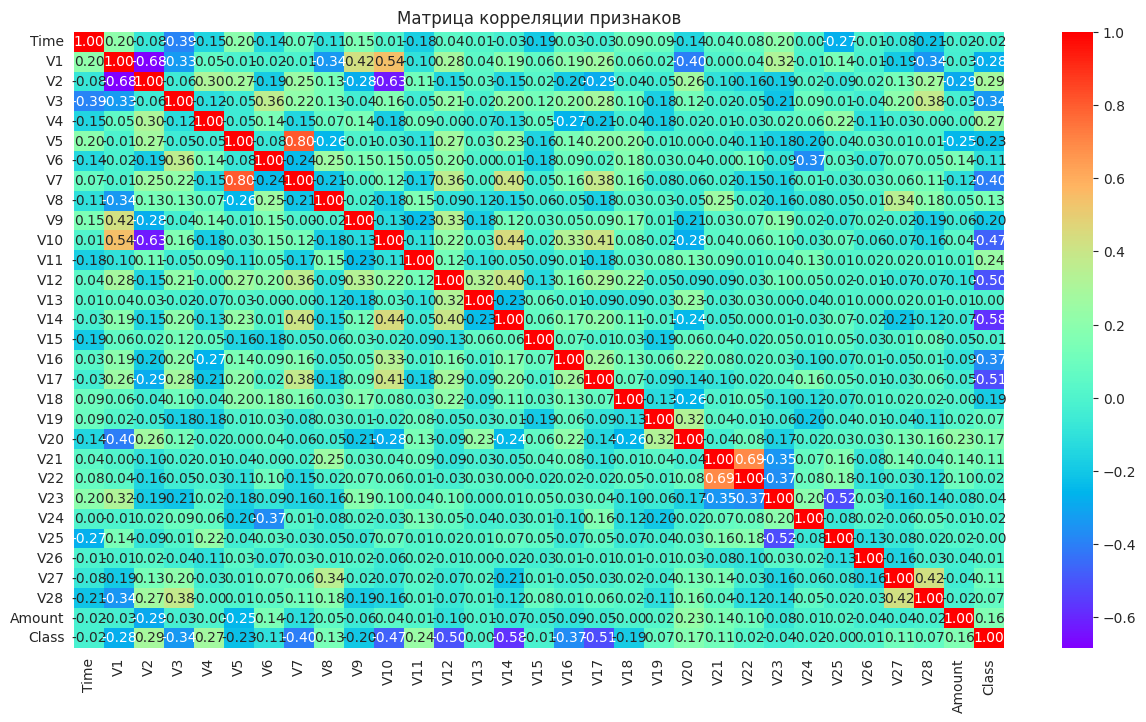

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df_merged.corr(),cmap='rainbow',fmt='.2f',annot=True)
plt.title('Матрица корреляции признаков')
plt.show()

**Вывод**
1. В данных не наблюдается мультиколлениарность.
2. Некоторые признаки ('Time','V13','V15','V22', 'V24','V25','V26') не играют существленного влияния на таргет

## Отбор признаков

**Задача** Чтобы построить эффективные модели, необходимо сначала отобрать значимые признаки. Для этого я использую модель случайного леса и извлеку значения важности признаков (Feature Importance) для дальнейшего анализа.

In [ ]:
model = RandomForestClassifier(class_weight = 'balanced', random_state = RANDOM_STATE,n_estimators = 100 )
y = df_merged['Class']
X = df_merged.drop(['Class'],axis = 1)
X_train,X_test,y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred = model.predict(X_test)
recall_score(y_test,y_pred)

0.9157894736842105

In [ ]:
df_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
df_importance.sort_values(by ='Importance' ,ascending=False)

,Feature,Importance
14,V14,0.183343
12,V12,0.111437
4,V4,0.108144
10,V10,0.105986
17,V17,0.089110
3,V3,0.068299
16,V16,0.050135
2,V2,0.042352
11,V11,0.034134
27,V27,0.025367


In [ ]:
roc_auc_score(y_test,y_pred)
f1_score(y_test,y_pred)

0.9560439560439561

In [ ]:
col_drop = list(df_importance.sort_values(by ='Importance' ,ascending=True)['Feature'])[:-3]
test_df = df_merged.copy()
roc =[]
f1 =[]
rec =[]
count_feat =[]
for col in col_drop:
  test_df.drop(col,axis = 1,inplace = True)
  model = RandomForestClassifier(class_weight = 'balanced', random_state = RANDOM_STATE,n_estimators = 100 )
  y = test_df['Class']
  X = test_df.drop(['Class'],axis = 1)
  X_train,X_test,y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  roc.append(roc_auc_score(y_test,y_pred))
  f1.append(f1_score(y_test,y_pred))
  rec.append(recall_score(y_test,y_pred))
  count_feat.append(len(X_train.columns))



Text(0, 0.5, 'ROC-AUC')

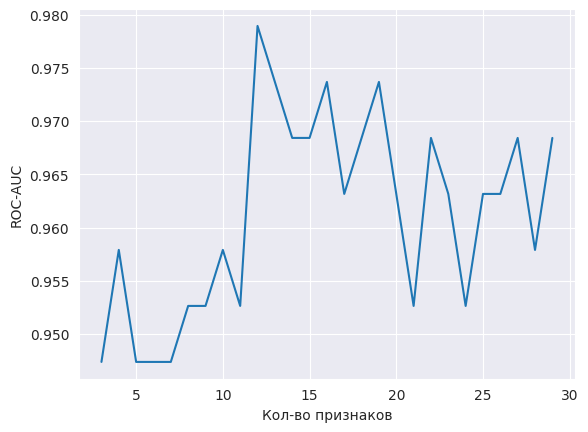

In [ ]:
plt.plot(count_feat, roc )
plt.xlabel('Кол-во признаков')
plt.ylabel('ROC-AUC')

Text(0, 0.5, 'F1')

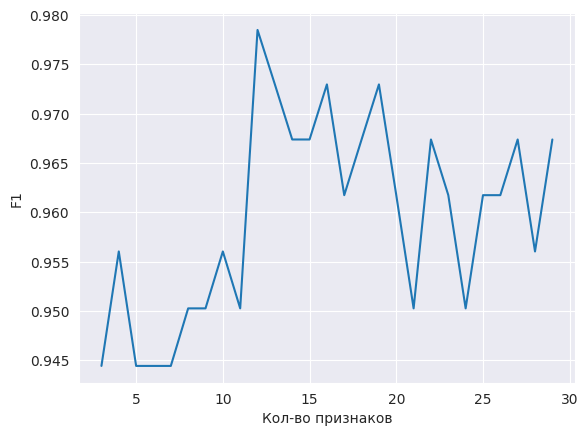

In [ ]:
plt.plot(count_feat, f1 )
plt.xlabel('Кол-во признаков')
plt.ylabel('F1')

Text(0, 0.5, 'recall')

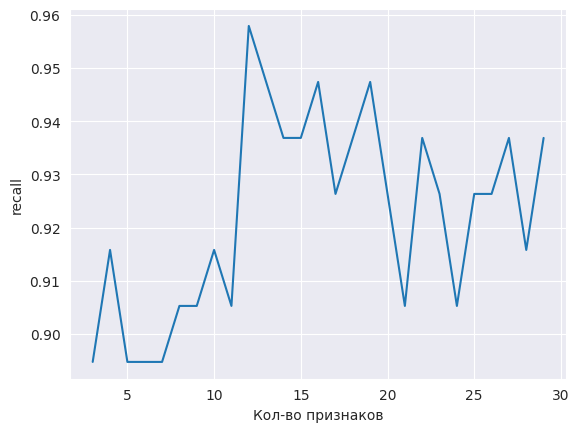

In [ ]:
plt.plot(count_feat, rec )
plt.xlabel('Кол-во признаков')
plt.ylabel('recall')

In [ ]:
col_drop = list(df_importance.sort_values(by ='Importance' ,ascending=True)['Feature'])[:18]
df_final = df_merged.copy()
df_final.drop(col_drop,axis=1,inplace =True)
df_final.to_csv('/content/drive/My Drive/Colab Notebooks/final_df.csv')

**Вывод**: Как видно из графиков, первые 12 признаков являются наилучшими для предсказания модели.


## Обучение моделей

**Задача** Построим пайплайн из моделей и выберем лучшую. В качестве итоговой метрики используем Recall, поскольку важно классифицировать все мошеннические как мошенические.

### Случай лес и логрегрессия

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,recall_score,f1_score,auc,precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_df.csv')
df.drop('Unnamed: 0', inplace = True, axis = 1)

In [ ]:
y=df['Class']
X=df.drop(['Class'],axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=RANDOM_STATE, shuffle=True)

In [ ]:
y_test.value_counts()

,count
Class,
0,27452
1,118


In [ ]:
y_train.value_counts()

,count
Class,
0,82354
1,355


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('undersampler', RandomUnderSampler(random_state=RANDOM_STATE)), # на самом деле этого можно было и не делать, поскольку оставшиеся модели в пайплайне учитывают дисбаланс классов
    ('classifier', LogisticRegression())
])

In [ ]:
param_grid = [
    {'classifier': [LogisticRegression(class_weight='balanced',random_state=RANDOM_STATE)],
     'classifier__C': [0.1, 1, 10],
     'classifier__solver':['liblinear','saga']
    },
    {
    'classifier': [RandomForestClassifier(class_weight='balanced',random_state=RANDOM_STATE)],
    'classifier__n_estimators': [100,200],
    'classifier__max_depth': [None, 10,20]
    }
]

In [ ]:
grid_searcher = GridSearchCV(pipeline,param_grid, cv = 5, scoring='roc_auc',n_jobs=-1)
grid_searcher.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('undersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(class_weight='balanced',
                                                            random_state=42)],
                          'classifier__C': [0.1, 1, 10],
                          'classifier__solver': ['liblinear', 'saga']},
                         {'classifier': [RandomForestClassifier(class_weight='balanced',
                                                                random_state=42)],
                          'classifier__max_depth': [None, 10, 20],
                          'classifier__n_estimators': [100, 200]}],
             scoring='roc_auc')

In [ ]:
grid_searcher.best_score_

0.9873603191646694

Метрика ROC-AUC на валидации

In [ ]:
grid_searcher.best_params_

{'classifier': RandomForestClassifier(class_weight='balanced', random_state=42),
 'classifier__max_depth': 10,
 'classifier__n_estimators': 200}

In [ ]:
y_pred = grid_searcher.predict(X_test)
roc_auc_score(y_test,y_pred)

0.9800755463465353

In [ ]:
recall_score(y_test,y_pred)

0.9745762711864406

In [ ]:
f1_score(y_test,y_pred)

0.3656597774244833

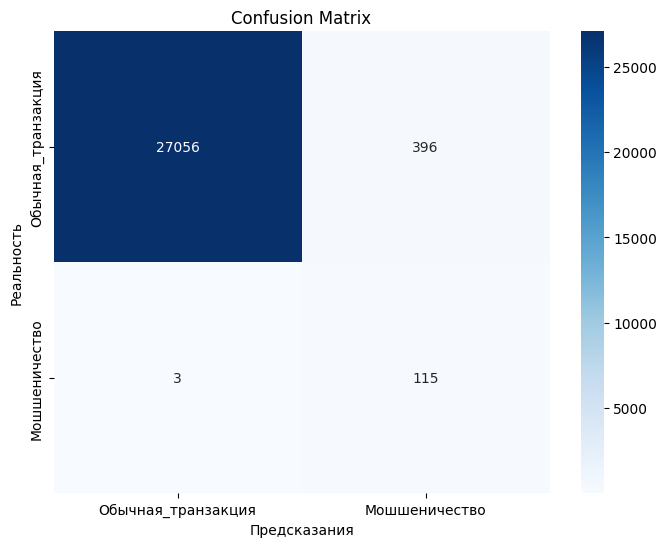

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Обычная_транзакция', 'Мошшеничество'], yticklabels=['Обычная_транзакция', 'Мошшеничество'])
plt.xlabel('Предсказания')
plt.ylabel('Реальность')
plt.title('Confusion Matrix')
plt.show()

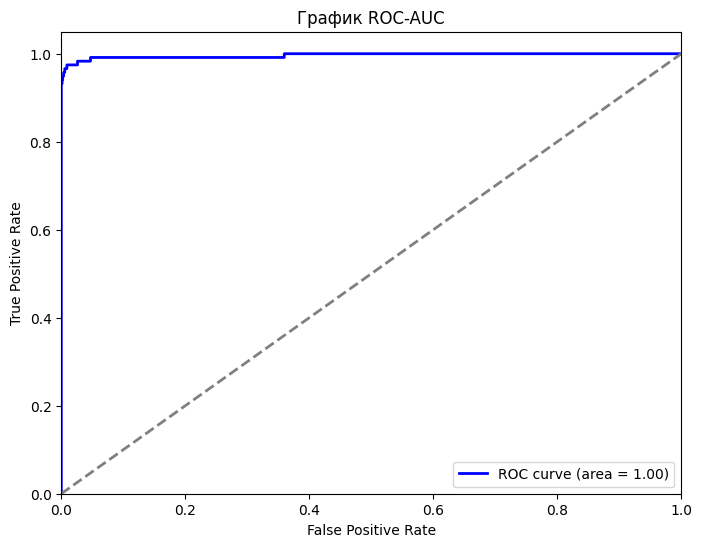

In [ ]:
y_prob = grid_searcher.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-AUC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
thresholds= np.linspace(0,1,11) # Вы можете попробовать различные значения порога
recall =[]
precisson =[]
for threshold in thresholds:
  y_pred_adjusted = (y_prob >= threshold).astype(int)
  recall.append(recall_score(y_test, y_pred_adjusted))
  precisson.append(precision_score(y_test, y_pred_adjusted))


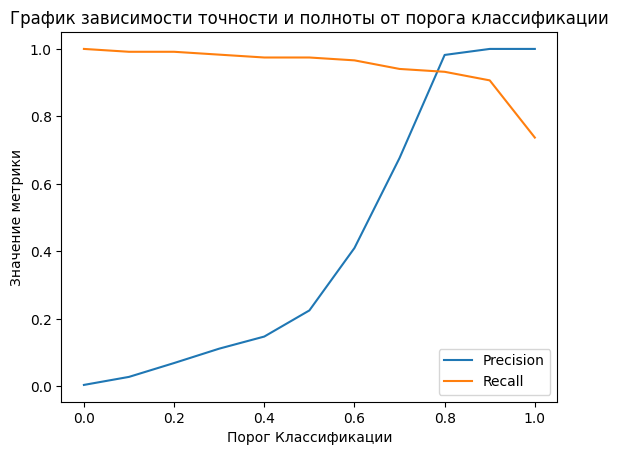

In [ ]:
plt.plot(thresholds,precisson, label ='Precision')
plt.plot(thresholds,recall,label ='Recall')
plt.title('График зависимости точности и полноты от порога классификации')
plt.xlabel('Порог Классификации')
plt.ylabel('Значение метрики')
plt.legend()
plt.show()

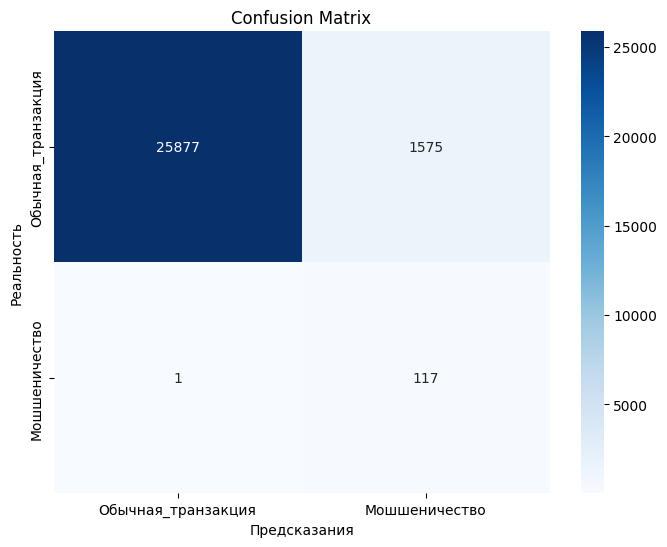

In [ ]:
y_pred_final = (y_prob >= 0.2).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Обычная_транзакция', 'Мошшеничество'], yticklabels=['Обычная_транзакция', 'Мошшеничество'])
plt.xlabel('Предсказания')
plt.ylabel('Реальность')
plt.title('Confusion Matrix')
plt.show()

**Вывод**: 
1. Случайный лес показал разделительную способность на классы в районе 0.99
2. Если не брать в расчет Precision, то наилучшим поорогом для разделения на классы будет около 0.2. Безусловно многие обычные транзакции будут предсказываться как мошшенические, но для антифрода важна именно полнота классификации мошеннических транзакций.

### LightGBM и XGBoost



In [ ]:
lgbm = LGBMClassifier(class_weight='balanced',random_state=RANDOM_STATE)
lgbm_grid = {'num_leaves': [31,50],
             'max_depth': [-1,10,20],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [100, 200]}


In [ ]:
grid_lgbm = GridSearchCV(lgbm,lgbm_grid, cv = 5, scoring='roc_auc',n_jobs=-1)
grid_lgbm.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 355, number of negative: 82354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 82709, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [-1, 10, 20], 'n_estimators': [100, 200],
                         'num_leaves': [31, 50]},
             scoring='roc_auc')

In [ ]:
grid_lgbm.best_score_

0.9851304147371429

In [ ]:
xgbm = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
xgbm_grid = {'max_depth': [3,5,10],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [100, 200],
             'scale_pos_weight': [10, 20]}

In [ ]:
grid_xgbm = GridSearchCV(xgbm,xgbm_grid, cv = 5, scoring='roc_auc',n_jobs=-1)
grid_xgbm.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:43:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200],
                         'scale_pos_weight': [10, 20]},
             scoring='roc_auc')

In [ ]:
grid_xgbm.best_score_

0.9865726214225725

```
conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Обычная_транзакция', 'Мошшеничество'], yticklabels=['Обычная_транзакция', 'Мошшеничество'])
plt.xlabel('Предсказания')
plt.ylabel('Реальность')
plt.title('Confusion Matrix')
plt.show()
```
![image.png](attachment:bfa842ae-9f23-4826-8e51-08dd79f800a1.png)

**Вывод**:
1. Наилучшей моделью оказался Случайный лес.
2. Xgboost и LightGBM показали себя чуть хуже, чем случайный лес.
3. Итоговой моделью будет являться случайный лес с порогом классификации 0.2 (те если вероятность мошшеничества выше данного значения, то модель будет попределять как мошшеническая)

## Общий вывод

В данной работе мной были получены следующие результаты:  
1. В данных не было пропусков, но содержались дубликаты, которые впоследствии мной были устранены.
2. Данные были разбиты на мошеннические транзакции и обычные, затем для обычных транзакций были удалены выбросы и аномалии.
3. Большинство признаков имеет распределение напоминающее нормальное по форме, признак 'Time' был приведен к логарифмическому виду для приближения к нормальному распредлелению.
4. Из признаков были отобраны следующие 12 признаков [V14,V12,V4,V10,V17,V3,V16,V2,V11,V27,V9,Amount] на основе модели случайного леса.
5. Наилушчей моделью оказался случайный лес с roc-auc на тестовых данных 0.98 и recall 0.99